In [1]:
import numpy as np
import tensorflow as tf
import json, os, sys, math, time, random, joblib

In [2]:
# seq to seq model
data = json.load(open('data.json', 'r'))
data = np.array(data)

input_texts = data[:, 0]
target_texts = data[:, 1]

print(input_texts.shape, target_texts.shape)
[print(input_texts[i], target_texts[i].strip()) for i in range(10)];

(10000,) (10000,)
Go. Ve.
Go. Vete.
Go. Vaya.
Go. Váyase.
Hi. Hola.
Run! ¡Corre!
Run! ¡Corran!
Run! ¡Huye!
Run! ¡Corra!
Run! ¡Corred!


In [3]:
# vocab is sorted by frequency
input_corpus = [char for word in input_texts for char in word]
target_corpus = [char for word in target_texts for char in word]

input_vocab = ["<PAD>", "<UNK>", "<SOS>", "<EOS>", *sorted(set(input_corpus), key=input_corpus.count, reverse=True)]
target_vocab = ["<SOS>", "<EOS>", *sorted(set(target_corpus), key=target_corpus.count, reverse=True)]

del input_corpus, target_corpus

input_vocab_size = len(input_vocab)
target_vocab_size = len(target_vocab)

char2idx_input = {char: idx for idx, char in enumerate(input_vocab)}
char2idx_target = {char: idx for idx, char in enumerate(target_vocab)}

In [4]:
input_vocab_size, target_vocab_size

(73, 84)

In [5]:
def vectorize(input_list: list[str]) -> list[list[int]]:
    return [[char2idx_input[c] if c in char2idx_input else char2idx_input["<UNK>"] for c in list(seq)] for seq in input_list]


def vectorize_target(input_list: list[str]) -> list[list[int]]:
    return [[char2idx_target[c] if c in char2idx_target else char2idx_target["<UNK>"] for c in list(seq)] for seq in input_list]

def decode(target_list: list[list[int]]) -> list[str]:
    return ["".join([target_vocab[c] for c in list(seq)]) for seq in target_list]

In [6]:
vectorize(["hello\\ world", " a a a a "]), decode([[0,1,2,3,4,5,6], [11]])

([[14, 5, 16, 16, 6, 1, 4, 23, 6, 13, 16, 17], [4, 9, 4, 9, 4, 9, 4, 9, 4]],
 ['<SOS><EOS> eoas', 'i'])

In [7]:
EMBEDDING_DIM = 128
LSTM_UNITS = 128

def make_model():
    encoder_input = tf.keras.layers.Input(shape=(input_vocab_size))
    encoder_embedded = tf.keras.layers.Embedding(input_vocab_size, EMBEDDING_DIM)(encoder_input)
    encoder_output, state_h, state_c = tf.keras.layers.LSTM(LSTM_UNITS, return_state=True)(encoder_embedded)
    encoder_state = [state_h, state_c]

    decoder_input = tf.keras.layers.Input(shape=(target_vocab_size))
    decoder_embedded = tf.keras.layers.Embedding(target_vocab_size, EMBEDDING_DIM)(decoder_input)
    decoder_output = tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=True)(decoder_embedded, initial_state=encoder_state)
    output = tf.keras.layers.Dense(target_vocab_size, activation="softmax")(decoder_output)

    model = tf.keras.models.Model([encoder_input, decoder_input], output)
    return model

In [8]:
def prepare_training_data():
    EOS_token_input = input_vocab.index("<EOS>")
    EOS_token_target = target_vocab.index("<EOS>")
    SOS_token_target = target_vocab.index("<SOS>")
    enc_input = [[*x, EOS_token_input] for x in vectorize(input_texts)]
    dec_vec = [[SOS_token_target, *x, EOS_token_target] for x in vectorize_target(target_texts)]

    # turn to ragged tensor
    enc_input = tf.ragged.constant(enc_input, dtype=tf.int32)
    # dec_vec = tf.ragged.constant(dec_vec, dtype=tf.int32)

    # dec_input is [SOS, x0, x1, ..., xn]
    # dec_target is [x0, x1, ..., xn, EOS]
    dec_input = tf.ragged.constant([x[:-1] for x in dec_vec], dtype=tf.int32)
    dec_target = tf.ragged.constant([x[1:] for x in dec_vec], dtype=tf.int32)

    return [enc_input, dec_input], dec_target

In [9]:
[X1, X2], y = prepare_training_data()

2023-08-14 11:49:21.430162: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-14 11:49:21.430747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [10]:
X1[1], X2[1], y[1]

(<tf.Tensor: shape=(4,), dtype=int32, numpy=array([41,  6,  7,  3], dtype=int32)>,
 <tf.Tensor: shape=(6,), dtype=int32, numpy=array([ 0, 47,  3, 10,  3,  7], dtype=int32)>,
 <tf.Tensor: shape=(6,), dtype=int32, numpy=array([47,  3, 10,  3,  7,  1], dtype=int32)>)

In [11]:
# Split the data into training and testing sets
indices = tf.range(start=0, limit=tf.shape(y)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

[X1, X2, y] = [tf.gather(params=params, indices=shuffled_indices) for params in [X1, X2, y]]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 73)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 84)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 73, 128)      9344        ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 84, 128)      10752       ['input_4[0][0]']                
                                                                                            

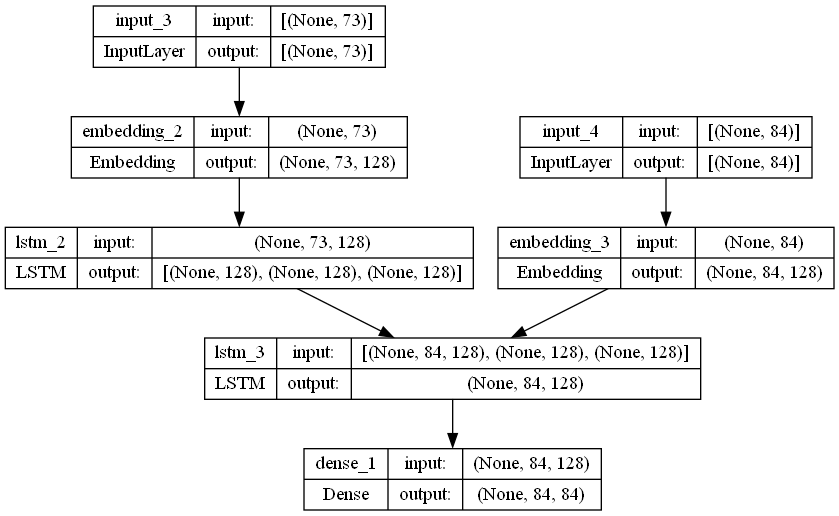

In [ ]:
model = make_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [X1, X2],
    y,
    batch_size=128,
    epochs=20,
)
# Save model
model.save("tmp/s2s1")

Epoch 1/20


c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/lstm_3/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/lstm_3/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/lstm_3/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/lstm_2/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/lstm_2/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense

InternalError: Graph execution error:

Detected at node 'Adam/gradients/zeros_like_2' defined at (most recent call last):
    File "c:\Users\shiva\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\shiva\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\shiva\miniconda3\envs\tf\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "c:\Users\shiva\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\shiva\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\shiva\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-23-16d6a21d20a1>", line 4, in <module>
      model.fit(
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'Adam/gradients/zeros_like_2'
Detected at node 'Adam/gradients/zeros_like_2' defined at (most recent call last):
    File "c:\Users\shiva\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\shiva\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\shiva\miniconda3\envs\tf\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "c:\Users\shiva\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\shiva\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\shiva\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-23-16d6a21d20a1>", line 4, in <module>
      model.fit(
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\shiva\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'Adam/gradients/zeros_like_2'
2 root error(s) found.
  (0) INTERNAL:  No unary variant unary_op function found for op ZEROS_LIKE Variant type_name: RaggedTensorVariant for device type: GPU
	 [[{{node Adam/gradients/zeros_like_2}}]]
	 [[Func/sparse_categorical_crossentropy/map/while/body/_11/input/_262/_146]]
  (1) INTERNAL:  No unary variant unary_op function found for op ZEROS_LIKE Variant type_name: RaggedTensorVariant for device type: GPU
	 [[{{node Adam/gradients/zeros_like_2}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_12135]